# Collaborative filtering

## Data loading

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
RANDOM_STATE = 5482

In [2]:
#df_users = pd.read_csv('data/train_triplets.txt', sep='\t', header=None, names=['user_id', 'song_id', 'play_count'])
df_users_raw = pd.read_csv('data/Million Song Dataset kaggle/User Listening History.csv')

In [3]:
df_music = pd.read_csv('data/Million Song Dataset kaggle/Music Info.csv')

In [4]:
df_users_raw.dtypes

track_id     object
user_id      object
playcount     int64
dtype: object

In [5]:
df_users_raw.shape

(9711301, 3)

In [6]:
num_distinct_users_raw = df_users_raw['user_id'].nunique()
num_distinct_users_raw

962037

We only take into account users that have listened more than 5 songs

In [7]:
df_user_counts = df_users_raw['user_id'].value_counts().reset_index()
df_user_counts.columns = ['user_id', 'count']
df_user_counts

,user_id,count
0,ec6dfcf19485cb011e0b22637075037aae34cf26,784
1,4e11f45d732f4861772b2906f81a7d384552ad12,384
2,726da71c2c2ea119119a7957517fccd028d1be76,376
3,113255a012b2affeab62607563d03fbdf31b08e7,367
4,7adec7f006cb09482d36609d205293d8b61f030e,366
...,...,...
962032,19e70c61de7bbb0ca3fc39c81a7e6b7eede69aa1,1
962033,7154895e6b692062033eecb3fe59ad240bb02811,1
962034,5d563bc9f80ddb3bce489c84b453409a88bd37e9,1
962035,779074ba35bd5f14913635819233a01dc5ecc9de,1


In [8]:
df_users = df_users_raw[df_users_raw['user_id'].isin(df_user_counts[df_user_counts['count'] > 5]['user_id'])].reset_index(drop=True)
#df_users = df_users_raw
df_users.shape

(8332242, 3)

In [9]:
num_distinct_users = df_users['user_id'].nunique()
num_distinct_users

464573

In [10]:
data_df = df_users_raw.groupby('track_id').size().reset_index(name='count')

In [11]:
data_df

,track_id,count
0,TRAAAED128E0783FAB,161
1,TRAAAHD128F42635A5,2
2,TRAAAQO12903CD8E1C,1
3,TRAABJS128F9325C99,945
4,TRAABXA128F9326351,18
...,...,...
30454,TRZZYMU128E0792400,1140
30455,TRZZZCL128F428BB80,19
30456,TRZZZCN128F9317A03,15
30457,TRZZZHL128F9329CFB,116


In [12]:
df_music.head()

,track_id,name,artist,spotify_preview_url,spotify_id,tags,genre,year,duration_ms,danceability,...,key,loudness,mode,speechiness,acousticness,instrumentalness,liveness,valence,tempo,time_signature
0,TRIOREW128F424EAF0,Mr. Brightside,The Killers,https://p.scdn.co/mp3-preview/4d26180e6961fd46...,09ZQ5TmUG8TSL56n0knqrj,"rock, alternative, indie, alternative_rock, in...",NaN,2004,222200,0.355,...,1,-4.360,1,0.0746,0.001190,0.000000,0.0971,0.240,148.114,4
1,TRRIVDJ128F429B0E8,Wonderwall,Oasis,https://p.scdn.co/mp3-preview/d012e536916c927b...,06UfBBDISthj1ZJAtX4xjj,"rock, alternative, indie, pop, alternative_roc...",NaN,2006,258613,0.409,...,2,-4.373,1,0.0336,0.000807,0.000000,0.2070,0.651,174.426,4
2,TROUVHL128F426C441,Come as You Are,Nirvana,https://p.scdn.co/mp3-preview/a1c11bb1cb231031...,0keNu0t0tqsWtExGM3nT1D,"rock, alternative, alternative_rock, 90s, grunge",RnB,1991,218920,0.508,...,4,-5.783,0,0.0400,0.000175,0.000459,0.0878,0.543,120.012,4
3,TRUEIND128F93038C4,Take Me Out,Franz Ferdinand,https://p.scdn.co/mp3-preview/399c401370438be4...,0ancVQ9wEcHVd0RrGICTE4,"rock, alternative, indie, alternative_rock, in...",NaN,2004,237026,0.279,...,9,-8.851,1,0.0371,0.000389,0.000655,0.1330,0.490,104.560,4
4,TRLNZBD128F935E4D8,Creep,Radiohead,https://p.scdn.co/mp3-preview/e7eb60e9466bc3a2...,01QoK9DA7VTeTSE3MNzp4I,"rock, alternative, indie, alternative_rock, in...",RnB,2008,238640,0.515,...,7,-9.935,1,0.0369,0.010200,0.000141,0.1290,0.104,91.841,4


In [13]:
df_music_info = df_music[['track_id', 'name', 'artist', 'energy']]
df_music_info.head()

,track_id,name,artist,energy
0,TRIOREW128F424EAF0,Mr. Brightside,The Killers,0.918
1,TRRIVDJ128F429B0E8,Wonderwall,Oasis,0.892
2,TROUVHL128F426C441,Come as You Are,Nirvana,0.826
3,TRUEIND128F93038C4,Take Me Out,Franz Ferdinand,0.664
4,TRLNZBD128F935E4D8,Creep,Radiohead,0.430


In [14]:
df_music_count = df_music_info.merge(
    df_users.groupby('track_id').size().reset_index(name='playcount'),
    on='track_id',
    how='left'
)
df_music_count = df_music_count.fillna(0)
print(df_music_count.shape)
df_music_count.head()

(50683, 5)


,track_id,name,artist,energy,playcount
0,TRIOREW128F424EAF0,Mr. Brightside,The Killers,0.918,32.0
1,TRRIVDJ128F429B0E8,Wonderwall,Oasis,0.892,283.0
2,TROUVHL128F426C441,Come as You Are,Nirvana,0.826,0.0
3,TRUEIND128F93038C4,Take Me Out,Franz Ferdinand,0.664,17.0
4,TRLNZBD128F935E4D8,Creep,Radiohead,0.430,0.0


In [15]:
# df_music_count = df_music_info.merge(
#     df_users.groupby('track_id').size().reset_index(name='playcount'),
#     on='track_id',
#     how='inner'
# )
# print(df_music_count.shape)
# df_music_count.head()

## Interaction Matrix

In [16]:
df_users_agg = df_users.groupby('user_id')['playcount'].agg(
    #total_playcount='sum',
    max_playcount='max'
).reset_index()
df_users_agg = df_users_agg.rename(columns={'playcount': 'max_playcount'})

In [17]:
df_users_rating = df_users.merge(df_users_agg, on='user_id')

In [18]:
from scipy.sparse import csr_matrix, csc_matrix

We codify each user and song to a unique integer ID

In [19]:
user_codes, user_uniques = pd.factorize(df_users['user_id'])
track_codes, track_uniques = pd.factorize(df_users['track_id'])

## Matrix Factorization: Alternating Least Squares (ALS)

Aleternating Least Squares performs very well for sparse and implicit data. So we shall calculate the interaction matrix as the playcount or as proposed in the original ALS paper:

$$
\text{confidence}_{ui} = 1 + \alpha \cdot r_{ui}
$$

We also calculate it with a bm25 weighting scheme to reduce the effect of a single user listening too many times to the same song and to direct somo of the confidence score to the most popular items, as proposed on the Implicit library documentation


In [20]:
ALPHA = 40 #Value proposed in the paper "A Matrix Factorization Approach to Online Recommendation with Implicit Feedback" by Hu et al. (2008)

confidence_values = 1 + ALPHA * df_users_rating['playcount']

interaction_matrix_user_item_paper = csr_matrix(
    (confidence_values, (user_codes, track_codes)),
    shape=(len(user_uniques), len(track_uniques))
)


In [21]:
from implicit.nearest_neighbours import bm25_weight


interaction_matrix_user_item_bm25_aux = csr_matrix(
    (df_users_rating['playcount'], (user_codes, track_codes)),
    shape=(len(user_uniques), len(track_uniques))
)

interaction_matrix_user_item_bm25 = bm25_weight(interaction_matrix_user_item_bm25_aux).tocsr() #We use K1 and B parameters as default values (K1=100, B=0.8)


c:\Users\danih\anaconda3\envs\MasterIA\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [22]:
from implicit.als import AlternatingLeastSquares

In [23]:
class ALSRecommender:
    def __init__(self, interaction_matrix, track_uniques, df_music_info, als_model=None):
        self.interaction_matrix = interaction_matrix
        self.track_uniques = track_uniques
        self.df_music_info = df_music_info

        if als_model is None:
            self.als_model = AlternatingLeastSquares(factors=50, regularization=0.1, iterations=20, num_threads=-1, random_state=RANDOM_STATE)
            self.als_model.fit(self.interaction_matrix)
        else:
            self.als_model = als_model

        self.user_index = None
        self.recommendations = None # List of tuples (track_id, energy, similarity, has been recommended)

    def make_recommendations(self, user_index, n=100):
        self.user_index = user_index

        user_items = self.interaction_matrix.tocsr()[user_index]


        top_n_recommendations_indexes, top_n_recommendations_scores = self.als_model.recommend(user_index, user_items, N=n, filter_already_liked_items=True)

        # for i in range(len(top_n_recommendations_indexes)):
        #     print(f"Track ID: {self.track_uniques[top_n_recommendations_indexes[i]]}, Similarity: {top_n_recommendations_scores[i]}")


        track_ids = self.track_uniques[top_n_recommendations_indexes].tolist()
        
        df_filtered = self.df_music_info.set_index('track_id').loc[track_ids][['energy']].reset_index()

        self.recommendations = [(track_id, energy, similarity, False) for (track_id, energy), similarity in zip(df_filtered.itertuples(index=False, name=None), top_n_recommendations_scores)]
        return self.recommendations

    
    def recommend_song(self, energy, energy_margin=0.05):
        if self.recommendations is None:
            raise ValueError("No recommendations available. Please call make_recommendations first.")
        
        closest_track_index = None
        distance_to_energy = float('inf')

        for i, (track_id, track_energy, similarity, has_been_recommended) in enumerate(self.recommendations):
            distance = abs(track_energy - energy)

            if not has_been_recommended and distance <= energy_margin:
                self.recommendations[i] = (track_id, track_energy, similarity, True)
                return (track_id, track_energy)
            
            if not has_been_recommended and distance < distance_to_energy:
                closest_track_index = i
                distance_to_energy = distance
        
        if closest_track_index is not None:
            track_id, track_energy, _, _= self.recommendations[closest_track_index]
            self.recommendations[closest_track_index] = (track_id, track_energy, similarity, True)
            return (track_id, track_energy)

        raise ValueError("All recommendations have already been recommended")


    def get_recommendations(self):
        if self.recommendations is None:
            raise ValueError("No recommendations available. Please call make_recommendations first.")
        return self.recommendations


    def get_recommendations_ids(self):
        if self.recommendations is None:
            raise ValueError("No recommendations available. Please call make_recommendations first.")
        return [track_id for track_id, _, _, _ in self.recommendations]
    
    def get_recommendations_info(self):
        track_ids = [track_id for track_id, _, _, _ in self.recommendations]
        df_ordered = self.df_music_info.set_index('track_id').loc[track_ids].reset_index()
        return df_ordered

### Example

In [36]:
user_index = 0 #User for wich recommendations will be made
user_listened_songs = df_users[df_users['user_id'] == user_uniques[user_index]].track_id
df_music_info[df_music_info['track_id'].isin(user_listened_songs)]

,track_id,name,artist,energy
79,TRAAHSY128F147BB5C,Speed of Sound,Coldplay,0.8980
796,TRDLMWP128F426BF6C,Ragged Wood,Fleet Foxes,0.6850
1158,TRPUGUW128F426BF6F,He Doesn't Know Why,Fleet Foxes,0.5580
1743,TRRYCBO128F932A2C7,Love Shack,The B-52's,0.9020
2350,TRFUPBA128F934F7E1,Paper Gangsta,Lady Gaga,0.5300
2585,TRVODUZ128F934D094,All That We Perceive,Thievery Corporation,0.8340
2722,TRHDDQG12903CB53EE,Heaven's Gonna Burn Your Eyes,Thievery Corporation,0.3370
5416,TRTUCUY128F92E1D24,Stacked Actors,Foo Fighters,0.9340
5428,TRLXSNR128F429361D,Generator,Foo Fighters,0.9240
5819,TRADVZX128F426BF79,Sun Giant,Fleet Foxes,0.0626


In [37]:
als_model_paper = AlternatingLeastSquares(factors=50, regularization=0.1, iterations=20, num_threads=-1, random_state=RANDOM_STATE)
als_model_paper.fit(interaction_matrix_user_item_paper)

100%|██████████| 20/20 [00:31<00:00,  1.56s/it]


In [38]:
als_recommender = ALSRecommender(interaction_matrix_user_item_paper, track_uniques, df_music_info, als_model=als_model_paper)
als_recommender.make_recommendations(0, n=20)
als_recommender.get_recommendations_info()

,track_id,name,artist,energy
0,TRXWAZC128F9314B3E,Heartbreak Warfare,John Mayer,0.5720
1,TRONYHY128F92C9D11,Revelry,Kings of Leon,0.7480
2,TRPFYYL128F92F7144,Float On,Modest Mouse,0.8930
3,TRRXGAK128EF349F1A,The Way I Are,Timbaland,0.9460
4,TRFTUIW128E0784B9F,Bubble Toes,Jack Johnson,0.5320
5,TRAEUIW12903D018F0,You And Your Heart,Jack Johnson,0.5520
6,TROWQGL128E0784BAA,Taylor,Jack Johnson,0.7250
7,TRZNAHL128F9327D5A,Gears,Miss May I,0.9750
8,TRWAUCC128F428E6FD,Staple It Together,Jack Johnson,0.7940
9,TRCQYJE128E078FA49,The News,Jack Johnson,0.0818


In [27]:
recommended_song = als_recommender.recommend_song(0.4)
df_music_info[df_music_info['track_id'] == recommended_song[0]]

,track_id,name,artist,energy
16769,TREQOIZ128F42BCE96,I'm Gonna Find Another You,John Mayer,0.342


In [28]:
als_model_bm25 = AlternatingLeastSquares(factors=50, regularization=0.1, iterations=20, num_threads=-1, random_state=RANDOM_STATE)
als_model_bm25.fit(interaction_matrix_user_item_bm25)

100%|██████████| 20/20 [00:31<00:00,  1.56s/it]


In [29]:
als_recommender_bm25 = ALSRecommender(interaction_matrix_user_item_bm25, track_uniques, df_music_info, als_model=als_model_bm25)
als_recommender_bm25.make_recommendations(0, n=20)
als_recommender_bm25.get_recommendations_info()

,track_id,name,artist,energy
0,TRCQYJE128E078FA49,The News,Jack Johnson,0.0818
1,TRFTUIW128E0784B9F,Bubble Toes,Jack Johnson,0.5320
2,TRWAUCC128F428E6FD,Staple It Together,Jack Johnson,0.7940
3,TRAEUIW12903D018F0,You And Your Heart,Jack Johnson,0.5520
4,TRJQRAP128F9314B3F,All We Ever Do Is Say Goodbye,John Mayer,0.5100
5,TRXWAZC128F9314B3E,Heartbreak Warfare,John Mayer,0.5720
6,TREQOIZ128F42BCE96,I'm Gonna Find Another You,John Mayer,0.3420
7,TROWQGL128E0784BAA,Taylor,Jack Johnson,0.7250
8,TRJZRTR128F9314B42,Perfectly Lonely,John Mayer,0.5300
9,TRXDINI128F146B94D,Rosemary,Deftones,0.6130


In [30]:
recommended_song = als_recommender_bm25.recommend_song(0.4)
df_music_info[df_music_info['track_id'] == recommended_song[0]]

,track_id,name,artist,energy
16769,TREQOIZ128F42BCE96,I'm Gonna Find Another You,John Mayer,0.342


### Experiments

#### Confidence value proposed in article vs bm25

In [31]:
random_generator = np.random.default_rng(seed=RANDOM_STATE)
random_users = random_generator.choice(np.arange(len(user_uniques)), size=20, replace=False)

first_different_recommendation = []

for rand_user in random_users:
    als_recommender = ALSRecommender(interaction_matrix_user_item_paper, track_uniques, df_music_info, als_model=als_model_paper)
    als_recommender.make_recommendations(rand_user, n=200)
    paper_recommendations = als_recommender.get_recommendations_ids()

    als_recommender = ALSRecommender(interaction_matrix_user_item_bm25, track_uniques, df_music_info, als_model=als_model_bm25)
    als_recommender.make_recommendations(rand_user, n=200)
    bm25_recommendations = als_recommender.get_recommendations_ids()

    for i in range(len(paper_recommendations)):
        if paper_recommendations[i] != bm25_recommendations[i]:
            first_different_recommendation.append(i)
            break
    else:
        first_different_recommendation.append(-1)

print("First different recommendation for each user: (-1 = every recommendation is the same)")
print(first_different_recommendation)

First different recommendation for each user: (-1 = every recommendation is the same)
[1, 1, 1, 1, 0, 1, 1, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]


In [32]:
analized_user = random_users[0]

als_recommender = ALSRecommender(interaction_matrix_user_item_paper, track_uniques, df_music_info, als_model=als_model_paper)
als_recommender.make_recommendations(analized_user, n=200)
paper_recommendations = als_recommender.get_recommendations_info()

als_recommender = ALSRecommender(interaction_matrix_user_item_bm25, track_uniques, df_music_info, als_model=als_model_bm25)
als_recommender.make_recommendations(analized_user, n=200)
bm25_recommendations = als_recommender.get_recommendations_info()

In [33]:
paper_recommendations.head(20)

,track_id,name,artist,energy
0,TRLVQME128F931BAF3,Vanilla Twilight,Owl City,0.523
1,TRJZRTR128F9314B42,Perfectly Lonely,John Mayer,0.530
2,TRVSJOM12903CD2DC1,One Less Lonely Girl,Justin Bieber,0.750
3,TRDGUPO128F9332CF6,Down To Earth,Bungle,0.904
4,TRSUSWW128F93463BF,Imma Be,Black Eyed Peas,0.539
5,TRBNYBX128F422EC61,Hey There Delilah,Plain White T's,0.261
6,TRGCHLH12903CB7352,Party In The U.S.A.,The Barden Bellas,0.360
7,TRCPXID128F92D5D3C,Halo,Depeche Mode,0.508
8,TRYEGSH12903CD2DCE,Overboard,Justin Bieber,0.790
9,TRTKLFX12903CD2DC2,First Dance,Justin Bieber,0.520


In [34]:
bm25_recommendations.head(20)

,track_id,name,artist,energy
0,TRLVQME128F931BAF3,Vanilla Twilight,Owl City,0.523
1,TRVSJOM12903CD2DC1,One Less Lonely Girl,Justin Bieber,0.750
2,TRDGUPO128F9332CF6,Down To Earth,Bungle,0.904
3,TRCKWGF12903CD2DCD,Never Let You Go,Third Eye Blind,0.940
4,TRJZRTR128F9314B42,Perfectly Lonely,John Mayer,0.530
5,TRYEGSH12903CD2DCE,Overboard,Justin Bieber,0.790
6,TRGCHLH12903CB7352,Party In The U.S.A.,The Barden Bellas,0.360
7,TRTKLFX12903CD2DC2,First Dance,Justin Bieber,0.520
8,TRZEDRT12903CD2DCC,Runaway Love,Justin Bieber,0.633
9,TRBNYBX128F422EC61,Hey There Delilah,Plain White T's,0.261


In [35]:
paper_ids = set(paper_recommendations['track_id'].head(50))
bm25_ids = set(bm25_recommendations['track_id'].head(50))
porcentaje = len(paper_ids & bm25_ids) / len(paper_ids) * 100
print(f"Percentage of paper recommendations that are in bm25 recomendations: {porcentaje:.2f}%")

Percentage of paper recommendations that are in bm25 recomendations: 78.00%


In [36]:
percentage_overlap_20 = []
percentage_overlap_50 = []
percentage_overlap_200 = []

for rand_user in random_users:
    als_recommender = ALSRecommender(interaction_matrix_user_item_paper, track_uniques, df_music_info, als_model=als_model_paper)
    als_recommender.make_recommendations(rand_user, n=200)
    paper_recommendations = als_recommender.get_recommendations_info()

    als_recommender = ALSRecommender(interaction_matrix_user_item_bm25, track_uniques, df_music_info, als_model=als_model_bm25)
    als_recommender.make_recommendations(rand_user, n=200)
    bm25_recommendations = als_recommender.get_recommendations_info()

    paper_ids_20 = set(paper_recommendations['track_id'].head(20))
    bm25_ids_20 = set(bm25_recommendations['track_id'].head(20))

    paper_ids_50 = set(paper_recommendations['track_id'].head(50))
    bm25_ids_50 = set(bm25_recommendations['track_id'].head(50))

    paper_ids_200 = set(paper_recommendations['track_id'])
    bm25_ids_200 = set(bm25_recommendations['track_id'])


    overlap = round(len(paper_ids_20 & bm25_ids_20) / len(paper_ids_20) * 100, 2)
    percentage_overlap_20.append(overlap)

    overlap = round(len(paper_ids_50 & bm25_ids_50) / len(paper_ids_50) * 100, 2)
    percentage_overlap_50.append(overlap)

    overlap = round(len(paper_ids_200 & bm25_ids_200) / len(paper_ids_200) * 100, 2)
    percentage_overlap_200.append(overlap)

print("Percentage of overlap between paper and bm25 recommendations for each user:")
print(f"First 20 recommendations: {percentage_overlap_20}")
print(f"First 50 recommendations: {percentage_overlap_50}")
print(f"First 200 recommendations: {percentage_overlap_200}")

print(f"Average percentage of overlap for 20 first recommendations: {np.mean(percentage_overlap_20):.2f}%")
print(f"Median percentage of overlap for 20 first recommendations: {np.median(percentage_overlap_20):.2f}%")

print(f"Average percentage of overlap for 50 first recommendations: {np.mean(percentage_overlap_50):.2f}%")
print(f"Median percentage of overlap for 50 first recommendations: {np.median(percentage_overlap_50):.2f}%")

print(f"Average percentage of overlap for 200 first recommendations: {np.mean(percentage_overlap_200):.2f}%")
print(f"Median percentage of overlap for 200 first recommendations: {np.median(percentage_overlap_200):.2f}%")

Percentage of overlap between paper and bm25 recommendations for each user:
First 20 recommendations: [80.0, 70.0, 70.0, 80.0, 85.0, 75.0, 65.0, 80.0, 85.0, 80.0, 35.0, 60.0, 70.0, 40.0, 35.0, 55.0, 5.0, 80.0, 80.0, 15.0]
First 50 recommendations: [78.0, 68.0, 72.0, 78.0, 80.0, 98.0, 76.0, 58.0, 76.0, 78.0, 46.0, 64.0, 72.0, 36.0, 46.0, 82.0, 16.0, 78.0, 76.0, 36.0]
First 200 recommendations: [67.0, 70.0, 69.0, 82.0, 71.5, 70.5, 89.0, 64.0, 74.5, 57.5, 57.0, 61.5, 83.0, 59.5, 47.5, 76.0, 37.0, 63.5, 67.5, 45.0]
Average percentage of overlap for 20 first recommendations: 62.25%
Median percentage of overlap for 20 first recommendations: 70.00%
Average percentage of overlap for 50 first recommendations: 65.70%
Median percentage of overlap for 50 first recommendations: 74.00%
Average percentage of overlap for 200 first recommendations: 65.62%
Median percentage of overlap for 200 first recommendations: 67.25%


In [179]:
from implicit.evaluation import leave_k_out_split, mean_average_precision_at_k
from scipy.sparse import lil_matrix
from tqdm import tqdm

In [175]:
#TODO: Eliminar, solo para pruebas
import numpy as np
from scipy.sparse import csr_matrix

def compare_matrices(train_matrix, test_matrix, full_matrix, limit=30):
    """
    Muestra las posiciones no nulas en train_matrix y test_matrix con sus respectivos valores
    también en la matriz original (full_matrix).

    Args:
        train_matrix (csr_matrix): Matriz de entrenamiento.
        test_matrix (csr_matrix): Matriz de prueba.
        full_matrix (csr_matrix): Matriz completa original.
        limit (int): Límite de valores a mostrar por matriz.
    """
    print("Valores no nulos en train_matrix:")
    train_coo = train_matrix.tocoo()
    for i, (r, c, v) in enumerate(zip(train_coo.row, train_coo.col, train_coo.data)):
        if i >= limit:
            break
        full_val = full_matrix[r, c]
        test_val = test_matrix[r, c]
        is_equal = True if full_val == v else False
        print(f"(fila {r}, col {c}): train={v}, test={test_val}, original={full_val}, is_equal={is_equal}")

    print("\nValores no nulos en test_matrix:")
    test_coo = test_matrix.tocoo()
    for i, (r, c, v) in enumerate(zip(test_coo.row, test_coo.col, test_coo.data)):
        if i >= limit:
            break
        full_val = full_matrix[r, c]
        train_val = train_matrix[r, c]
        is_equal_2 = True if full_val == v else False
        print(f"(fila {r}, col {c}): test={v}, train={train_val}, original={full_val}, is_equal={is_equal_2}")  


In [167]:
def build_split_from_indices(matrix, test_users, test_items):
    train_lil = matrix.tolil()
    test_lil = lil_matrix(matrix.shape)

   
    for u, i in zip(test_users, test_items):
        val = matrix[u, i]
        train_lil[u, i] = 0
        test_lil[u, i] = val

    
    train = train_lil.tocsr()
    test = test_lil.tocsr()
    return train, test

def generate_2_splits(interaction_matrix_1, interaction_matrix_2, k=1, random_state=RANDOM_STATE):
    train_matrix_1, test_matrix_1 = leave_k_out_split(interaction_matrix_1, K = k, random_state=random_state)
    test_users, test_items = test_matrix_1.nonzero()
    train_matrix_2, test_matrix_2 = build_split_from_indices(interaction_matrix_2, test_users, test_items)
    return train_matrix_1, test_matrix_1, train_matrix_2, test_matrix_2

In [168]:
train_matrix_paper, test_matrix_paper, train_matrix_bm25, test_matrix_bm25 = generate_2_splits(interaction_matrix_user_item_paper, interaction_matrix_user_item_bm25, k=1)

In [177]:
als_model_paper = AlternatingLeastSquares(factors=50, regularization=0.1, iterations=20, num_threads=-1, random_state=RANDOM_STATE)
als_model_paper.fit(train_matrix_paper)
score_paper = mean_average_precision_at_k(als_model_paper, train_matrix_paper, test_matrix_paper, K=20, num_threads=-1)

als_model_bm25 = AlternatingLeastSquares(factors=50, regularization=0.1, iterations=20, num_threads=-1, random_state=RANDOM_STATE)
als_model_bm25.fit(train_matrix_bm25)
score_bm25 = mean_average_precision_at_k(als_model_bm25, train_matrix_bm25, test_matrix_bm25, K=20, num_threads=-1)

100%|██████████| 464573/464573 [00:55<00:00, 8332.19it/s]


In [178]:
print(f"MAP@20 for original confidences: {score_paper:.4f}")
print(f"MAP@20 for BM25 confidences: {score_bm25:.4f}")

MAP@20 for original confidences: 0.0893
MAP@20 for BM25 confidences: 0.0842


In [181]:
random_states_list = [5873, 429, 9842, 7130, 1059, 886, 3247, 9011, 1678, 352]
paper_scores = []
bm25_scores = []
print("Evaluation of original and BM25 confidence matrices with 10 different train/test splits:")
for i in tqdm(range(10)):
    train_paper, test_paper, train_bm25, test_bm25 = generate_2_splits(interaction_matrix_user_item_paper, interaction_matrix_user_item_bm25, k=1, random_state=random_states_list[i])
    als_model_paper = AlternatingLeastSquares(factors=50, regularization=0.1, iterations=20, num_threads=-1, random_state=random_states_list[i])
    als_model_paper.fit(train_paper, show_progress=False)
    score_paper = mean_average_precision_at_k(als_model_paper, train_paper, test_paper, K=20, num_threads=-1, show_progress=False)
    paper_scores.append(score_paper)

    als_model_bm25 = AlternatingLeastSquares(factors=50, regularization=0.1, iterations=20, num_threads=-1, random_state=random_states_list[i])
    als_model_bm25.fit(train_bm25, show_progress=False)
    score_bm25 = mean_average_precision_at_k(als_model_bm25, train_bm25, test_bm25, K=20, num_threads=-1, show_progress=False)
    bm25_scores.append(score_bm25)

print("Evaluation completed.")

Evaluation of original and BM25 confidence matrices with 10 different train/test splits:


100%|██████████| 10/10 [37:13<00:00, 223.36s/it]

Evaluation completed.


In [183]:
print("Scores for original confidences:")
print(paper_scores)
print("Scores for BM25 confidences:")
print(bm25_scores)

Scores for original confidences:
[0.08896445002836646, 0.08915422417070401, 0.08989397600573149, 0.08958843864594061, 0.08935815102118516, 0.08935843005968298, 0.08954142005269897, 0.08935469925358973, 0.08910756228297675, 0.08871314916270552]
Scores for BM25 confidences:
[0.08422967660038869, 0.08444234670763376, 0.0842870391996571, 0.08453593440667856, 0.08441099266392685, 0.08381616742525742, 0.08454149355938541, 0.08472622613425947, 0.0836921808844973, 0.08446551724867414]


In [186]:
print("Original paper confidences:")
print(f"Average MAP@20: {np.mean(paper_scores):.4f}")
print("BM25 confidences:")
print(f"Average MAP@20: {np.mean(bm25_scores):.4f}")

Original paper confidences:
Average MAP@20: 0.0893
BM25 confidences:
Average MAP@20: 0.0843


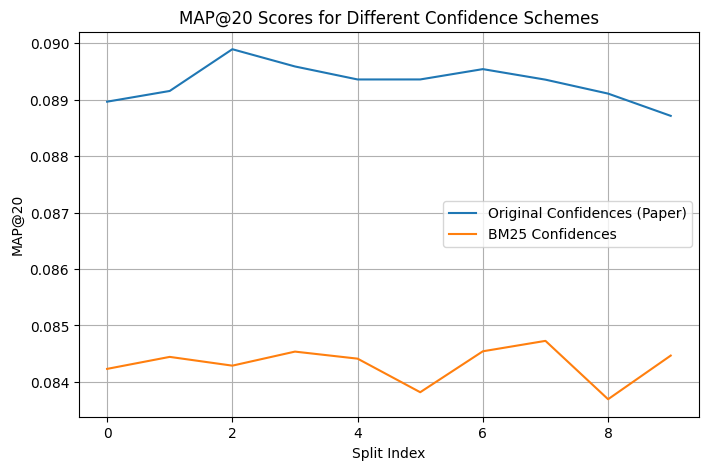

In [187]:
plt.figure(figsize=(8, 5))
plt.plot(paper_scores, label='Original Confidences (Paper)')
plt.plot(bm25_scores, label='BM25 Confidences')
plt.xlabel('Split Index')
plt.ylabel('MAP@20')
plt.title('MAP@20 Scores for Different Confidence Schemes')
plt.legend()
plt.grid(True)
plt.show()

The original paper method outperforms slightly to the bm25 aproach in every single train/test split, so we will use this confidences in the final model. Even so, the differences in results are very small, and the bm25 approach should present similar performance.

### Hyperparameters

In [222]:
from implicit.evaluation import leave_k_out_split, mean_average_precision_at_k, ndcg_at_k
from sklearn.model_selection import ParameterSampler

In [223]:
train_matrix_params, val_matrix_params = leave_k_out_split(interaction_matrix_user_item_paper, K = 1, random_state=RANDOM_STATE)

In [224]:
parameter_distribution = {
    'factors': [16, 32, 50, 64, 100, 128, 164, 200],
    'regularization': [0.001, 0.01, 0.1, 1.0],
    'alpha': [0.1, 1, 5, 10, 20, 50, 100]
}

random_params = list(ParameterSampler(parameter_distribution, n_iter=40, random_state=RANDOM_STATE))

In [225]:
random_params

[{'regularization': 0.1, 'factors': 128, 'alpha': 1},
 {'regularization': 0.01, 'factors': 50, 'alpha': 1},
 {'regularization': 0.001, 'factors': 200, 'alpha': 1},
 {'regularization': 0.001, 'factors': 16, 'alpha': 1},
 {'regularization': 1.0, 'factors': 128, 'alpha': 10},
 {'regularization': 0.01, 'factors': 200, 'alpha': 100},
 {'regularization': 1.0, 'factors': 164, 'alpha': 20},
 {'regularization': 0.001, 'factors': 100, 'alpha': 100},
 {'regularization': 0.01, 'factors': 32, 'alpha': 10},
 {'regularization': 0.1, 'factors': 100, 'alpha': 20},
 {'regularization': 0.01, 'factors': 64, 'alpha': 10},
 {'regularization': 1.0, 'factors': 200, 'alpha': 0.1},
 {'regularization': 0.001, 'factors': 128, 'alpha': 100},
 {'regularization': 0.01, 'factors': 16, 'alpha': 0.1},
 {'regularization': 1.0, 'factors': 100, 'alpha': 5},
 {'regularization': 1.0, 'factors': 50, 'alpha': 20},
 {'regularization': 0.1, 'factors': 64, 'alpha': 100},
 {'regularization': 1.0, 'factors': 100, 'alpha': 100},
 {

In [226]:
def study_params(train_matrix, val_matrix, params):
    map_scores = []
    ndcg_scores = []

    for params in tqdm(random_params):
        als_model = AlternatingLeastSquares(
            factors=params['factors'],
            regularization=params['regularization'],
            alpha=params['alpha'],
            iterations=20,
            random_state=RANDOM_STATE
        )
        
        als_model.fit(train_matrix, show_progress=False)
        score = mean_average_precision_at_k(als_model, train_matrix, val_matrix, K=20, num_threads=0, show_progress=False)
        ndcg_score = ndcg_at_k(als_model, train_matrix, val_matrix, K=20, num_threads=0, show_progress=False)

        map_scores.append(score)
        ndcg_scores.append(ndcg_score)

    return map_scores, ndcg_scores

In [ ]:
map_scores, ndcg_scores = study_params(train_matrix_params, val_matrix_params, random_params)

  0%|          | 0/40 [00:00<?, ?it/s]

In [ ]:
print("MAP@20 scores:")
print(map_scores)
print("NDCG@20 scores:")
print(ndcg_scores)

In [ ]:
with open('hyperparams.txt', 'w') as f:
    f.write('random_params = ' + repr(random_params) + '\n')
    f.write('map_scores = ' + repr(map_scores) + '\n')
    f.write('ndcg_scores = ' + repr(ndcg_scores) + '\n')

In [ ]:
best_map_idx = max(range(len(map_scores)), key=lambda i: map_scores[i])
best_ndcg_idx = max(range(len(ndcg_scores)), key=lambda i: ndcg_scores[i])

best_map_params = random_params[best_map_idx]
best_ndcg_params = random_params[best_ndcg_idx]

print(f"Best MAP: index={best_map_idx}, params={best_map_params}, MAP={map_scores[best_map_idx]}")
print(f"Best NDCG: index={best_ndcg_idx}, params={best_ndcg_params}, NDCG={ndcg_scores[best_ndcg_idx]}")
